In [16]:
import numpy as np
import cv2
import os
import csv
import rasterio
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import Conv2d as Conv2D
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Upsample
import random
from torch.utils.data import Dataset
import tifffile
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
from unet3 import * 
import warnings
warnings.filterwarnings("ignore")
import time


In [8]:
root_dir="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Data/"
train_path=root_dir+"txt/train.txt"
val_path=root_dir+"txt/val.txt"
with open(train_path, "r") as t:
    lines_train =t.readlines()
    list_train=[i[:-1] for i in lines_train]
with open(val_path, "r") as v:
    lines_val =v.readlines()
    list_val=[i[:-1] for i in lines_val]   

In [9]:
class SARDataset(Dataset):

    def __init__(self, data_list, preprocess_func):
        self.data_list = data_list
        self.preprocess_func = preprocess_func

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, i):
        return self.preprocess_func(self.data_list[i])

def processAndAugment(data):
    
    root_dir="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Data/"
    
    S1 = root_dir+"S1/"+data+"_S1Hand.tif"
    DEM = root_dir+"DEM/"+data+"_DEM.tif"
    Label=root_dir+"Label/"+data+"_LabelHand.tif"
    
    S1_data=np.nan_to_num(tifffile.imread(S1))
    DEM_data=tifffile.imread(DEM)
    Label_data=np.uint8(rasterio.open(Label).read())
   # Label_data[Label_data==255]=2
    #location = np.argwhere(Label_data==2).tolist()    
    
    arr_x = np.clip(S1_data, -50, 1)
    arr_x = (arr_x + 50) / 51
    S1_0_NORM = arr_x[0]
    S1_1_NORM = arr_x[1]

    #S1_data=np.nan_to_num(rasterio.open(S1).read())
   # DEM_data=rasterio.open(DEM).read()
    #Label_data=np.uint8(rasterio.open(Label).read())
    #Label_data[Label_data==255]=2
    #location = np.argwhere(Label_data==2).tolist()
    
    DEM_NORM=(DEM_data - np.min(DEM_data)) / (np.max(DEM_data) - np.min(DEM_data))
#    S1_0_NORM = (S1_data[0] - np.min(S1_data[0])) / (np.max(S1_data[0]) - np.min(S1_data[0]))
#    S1_1_NORM = (S1_data[1] - np.min(S1_data[1])) / (np.max(S1_data[1]) - np.min(S1_data[1]))

   # for l in location:
   #     DEM_NORM[l[0],l[1],l[2]]=0
   #     S1_0_NORM[l[1],l[2]]=0
   #     S1_1_NORM[l[1],l[2]]=0
    
    S1_0_NORM = np.expand_dims(S1_0_NORM, axis=0)
    S1_1_NORM = np.expand_dims(S1_1_NORM, axis=0)
    S0_NORM = torch.from_numpy(S1_0_NORM)#.float
    S1_NORM = torch.from_numpy(S1_1_NORM)#.float
    DEM = torch.from_numpy(DEM_NORM)#.float
    Label = torch.from_numpy(Label_data).squeeze().long()
    
    SUM = torch.cat((S0_NORM,S1_NORM,DEM),dim=0)
    #x= torch.tensor(SUM, dtype=torch.float32)
    #X_data = np.stack((S1_0_NORM, S1_1_NORM, DEM_NORM), axis=0)  
    
   # x_transforms = transforms.Compose([
  #  transforms.ToTensor(),
  #  transforms.Normalize([0.5], [0.5])])

# mask只需要转换为tensor
  #  y_transforms = transforms.ToTensor()
    
    return SUM,Label

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def computeIOU(output, target):
    
    output = torch.argmax(output, dim=1).flatten() 
    target = target.flatten()

    no_ignore = target.ne(255).cuda()
    output = output.masked_select(no_ignore)
    target = target.masked_select(no_ignore)
    intersection = torch.sum(output * target)
    union = torch.sum(target) + torch.sum(output) - intersection
    iou = (intersection + .0000001) / (union + .0000001)

    return iou

def computeAccuracy(output, target):
    output = torch.argmax(output, dim=1).flatten() 
    target = target.flatten()

    no_ignore = target.ne(255).cuda()
    output = output.masked_select(no_ignore)
    target = target.masked_select(no_ignore)
    correct = torch.sum(output.eq(target))

    return correct.float() / len(target)

In [13]:
model = unet3(3,3).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_dataset = SARDataset(list_train, processAndAugment)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
val_dataset = SARDataset(list_val, processAndAugment)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

In [17]:
def train_model(model, criterion, optimizer, dataload, val, num_epochs=2):
    global running_loss
    global running_iou
    global running_count
    global running_accuracy
    global max_valid_iou
    
    global training_losses
    global training_accuracies
    global training_ious
    global valid_losses
    global valid_accuracies
    global valid_ious
    global epochs 
    max_valid_iou = 0
    
    training_losses = []
    training_accuracies = []
    training_ious = []
    valid_losses = []
    valid_accuracies = []
    valid_ious = []
    epochs = []
   
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        start = time.time()
        dt_size = len(dataload.dataset)
        val_size = len(val.dataset)
        running_loss = 0
        running_iou = 0
        running_count = 0
        running_accuracy = 0
        #epoch_loss = 0
        #step = 0
        for x, y in dataload:
            x= torch.tensor(x, dtype=torch.float32)
            #y= torch.tensor(y, dtype=torch.float32)
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_iou += computeIOU(outputs, labels)
            running_accuracy += computeAccuracy(outputs, labels)
            running_count += 1
            #print("%d/%d,train_loss:%0.3f" % (running_count, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        #print("epoch %d loss:%0.3f" % (epoch, running_loss/running_count))
        
        model = model.eval()
        count = 0
        iou = 0
        loss = 0
        accuracy = 0
        with torch.no_grad():
            for x, y in val:
                x= torch.tensor(x, dtype=torch.float32)
                model = model.to(device)
                inputs = x.to(device)
                labels = y.to(device)
                outputs = model(inputs)
                valid_loss = criterion(outputs, labels)
                valid_iou = computeIOU(outputs, labels)
                valid_accuracy = computeAccuracy(outputs, labels)
                iou += valid_iou
                loss += valid_loss
                accuracy += valid_accuracy
                count += 1

        iou = iou / count
        accuracy = accuracy / count

        if iou > max_valid_iou:
            max_valid_iou = iou
            aaa="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/"
            file= "{}_{}.pth".format(epoch, iou.item())     
            save_path = aaa+file
            torch.save(model.state_dict(), save_path)
            print("model saved at", save_path)

        loss = loss / count
        end = time.time()
        print("epoch:" ,epoch)
        print("time:" ,end-start)
        print("Training Loss:", running_loss / running_count)
        print("Training IOU:", (running_iou / running_count).item())
        print("Training Accuracy:", (running_accuracy / running_count).item())
        print("Validation Loss:", loss.item())
        print("Validation IOU:", iou.item())
        print("Validation Accuracy:", accuracy.item())


        training_losses.append((running_loss / running_count))
        training_accuracies.append((running_accuracy / running_count).item())
        training_ious.append((running_iou / running_count).item())
        valid_losses.append(loss.item())
        valid_accuracies.append(accuracy.item())
        valid_ious.append(iou.item())    
        epochs.append(epoch)
        
        
        
        
        
#    aaa="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/"
#    torch.save(model.state_dict(), aaa+'weights_%d.pth' % epoch)
#    return model

In [18]:
train_model(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs=500)

Epoch 0/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/0_0.23959322273731232.pth
epoch: 0
time: 31.684508323669434
Training Loss: 0.16442490911755997
Training IOU: 0.3421333432197571
Training Accuracy: 0.943278968334198
Validation Loss: 0.1724514216184616
Validation IOU: 0.23959322273731232
Validation Accuracy: 0.9415392279624939
Epoch 1/499
----------
epoch: 1
time: 31.92503786087036
Training Loss: 0.16278363750555003
Training IOU: 0.3619591295719147
Training Accuracy: 0.9459111094474792
Validation Loss: 0.16475902497768402
Validation IOU: 0.22839364409446716
Validation Accuracy: 0.941414475440979
Epoch 2/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/2_0.24524976313114166.pth
epoch: 2
time: 32.274245738983154
Training Loss: 0.1514216331550135
Training IOU: 0.36549708247184753
Training Accuracy: 0.9490789771080017
Validation Loss: 0.16749952733516693
Validation IOU: 0.24524976313114166
Valida

epoch: 27
time: 33.67194437980652
Training Loss: 0.12460992333497135
Training IOU: 0.4213327169418335
Training Accuracy: 0.9545167088508606
Validation Loss: 0.13094259798526764
Validation IOU: 0.3415806293487549
Validation Accuracy: 0.9514904618263245
Epoch 28/499
----------
epoch: 28
time: 33.654553174972534
Training Loss: 0.12931268186403963
Training IOU: 0.42159077525138855
Training Accuracy: 0.9560746550559998
Validation Loss: 0.16129614412784576
Validation IOU: 0.29605403542518616
Validation Accuracy: 0.9460251927375793
Epoch 29/499
----------
epoch: 29
time: 33.65649771690369
Training Loss: 0.11437759866105178
Training IOU: 0.4296658933162689
Training Accuracy: 0.9601897597312927
Validation Loss: 0.1297989934682846
Validation IOU: 0.34274259209632874
Validation Accuracy: 0.9512409567832947
Epoch 30/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/30_0.36553746461868286.pth
epoch: 30
time: 33.879733085632324
Training Loss: 0.11347775673

model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/56_0.3796670138835907.pth
epoch: 56
time: 33.731462478637695
Training Loss: 0.09444380275463352
Training IOU: 0.4806059002876282
Training Accuracy: 0.9653348922729492
Validation Loss: 0.12155906856060028
Validation IOU: 0.3796670138835907
Validation Accuracy: 0.9574793577194214
Epoch 57/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/57_0.38972654938697815.pth
epoch: 57
time: 33.75467920303345
Training Loss: 0.08998075868368734
Training IOU: 0.49466657638549805
Training Accuracy: 0.9673145413398743
Validation Loss: 0.1170935183763504
Validation IOU: 0.38972654938697815
Validation Accuracy: 0.9568797945976257
Epoch 58/499
----------
epoch: 58
time: 33.6982216835022
Training Loss: 0.09511166224136758
Training IOU: 0.491931676864624
Training Accuracy: 0.9659637212753296
Validation Loss: 0.11929124593734741
Validation IOU: 0.386204332113266
Validation Accuracy: 0.956

epoch: 83
time: 33.760955572128296
Training Loss: 0.06668094445679647
Training IOU: 0.5912063121795654
Training Accuracy: 0.9759559631347656
Validation Loss: 0.10586205869913101
Validation IOU: 0.420920729637146
Validation Accuracy: 0.9636394381523132
Epoch 84/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/84_0.42975279688835144.pth
epoch: 84
time: 33.80548644065857
Training Loss: 0.06447476699488619
Training IOU: 0.578658401966095
Training Accuracy: 0.976695716381073
Validation Loss: 0.10799223929643631
Validation IOU: 0.42975279688835144
Validation Accuracy: 0.963514506816864
Epoch 85/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/85_0.44250723719596863.pth
epoch: 85
time: 33.799707651138306
Training Loss: 0.06510570833238606
Training IOU: 0.5729019045829773
Training Accuracy: 0.9762124419212341
Validation Loss: 0.10087749361991882
Validation IOU: 0.44250723719596863
Validation Accuracy: 0.9

epoch: 110
time: 33.77442979812622
Training Loss: 0.054524553908450825
Training IOU: 0.6302465200424194
Training Accuracy: 0.9794642329216003
Validation Loss: 0.09486209601163864
Validation IOU: 0.4885145127773285
Validation Accuracy: 0.9679154753684998
Epoch 111/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/111_0.4961828291416168.pth
epoch: 111
time: 33.803234815597534
Training Loss: 0.050428560901379496
Training IOU: 0.6503969430923462
Training Accuracy: 0.9805854558944702
Validation Loss: 0.0961492657661438
Validation IOU: 0.4961828291416168
Validation Accuracy: 0.9693621397018433
Epoch 112/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/112_0.5161401033401489.pth
epoch: 112
time: 33.883822441101074
Training Loss: 0.04838468287086401
Training IOU: 0.6442404985427856
Training Accuracy: 0.981287956237793
Validation Loss: 0.09251242130994797
Validation IOU: 0.5161401033401489
Validation Accura

model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/138_0.5296811461448669.pth
epoch: 138
time: 33.816022634506226
Training Loss: 0.04260924100113838
Training IOU: 0.6545851230621338
Training Accuracy: 0.9832183718681335
Validation Loss: 0.09100499749183655
Validation IOU: 0.5296811461448669
Validation Accuracy: 0.9711408615112305
Epoch 139/499
----------
epoch: 139
time: 33.759273290634155
Training Loss: 0.044266525938674486
Training IOU: 0.6759426593780518
Training Accuracy: 0.9825855493545532
Validation Loss: 0.09835078567266464
Validation IOU: 0.5011773705482483
Validation Accuracy: 0.9696075320243835
Epoch 140/499
----------
epoch: 140
time: 33.80224251747131
Training Loss: 0.0459157638559144
Training IOU: 0.664628803730011
Training Accuracy: 0.9817861914634705
Validation Loss: 0.10197686403989792
Validation IOU: 0.5238187313079834
Validation Accuracy: 0.9709460139274597
Epoch 141/499
----------
epoch: 141
time: 33.738338232040405
Training Loss: 0.042652

epoch: 166
time: 33.759132385253906
Training Loss: 0.03974622810477367
Training IOU: 0.7085837125778198
Training Accuracy: 0.9841405749320984
Validation Loss: 0.10152629017829895
Validation IOU: 0.5520181655883789
Validation Accuracy: 0.9711158275604248
Epoch 167/499
----------
epoch: 167
time: 33.755868911743164
Training Loss: 0.043575364092574974
Training IOU: 0.6988599896430969
Training Accuracy: 0.9827090501785278
Validation Loss: 0.09343709796667099
Validation IOU: 0.5517995953559875
Validation Accuracy: 0.9716376066207886
Epoch 168/499
----------
epoch: 168
time: 33.759294509887695
Training Loss: 0.040197761056811616
Training IOU: 0.716472864151001
Training Accuracy: 0.9836603999137878
Validation Loss: 0.1020524650812149
Validation IOU: 0.5288859009742737
Validation Accuracy: 0.9713066220283508
Epoch 169/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/169_0.572080135345459.pth
epoch: 169
time: 33.862632751464844
Training Loss: 0.03757

epoch: 195
time: 33.76726150512695
Training Loss: 0.034843158149716405
Training IOU: 0.7422394752502441
Training Accuracy: 0.9856339693069458
Validation Loss: 0.10558890551328659
Validation IOU: 0.5792608857154846
Validation Accuracy: 0.9725998640060425
Epoch 196/499
----------
epoch: 196
time: 33.73568558692932
Training Loss: 0.035982710375113434
Training IOU: 0.7281908392906189
Training Accuracy: 0.9852087497711182
Validation Loss: 0.0882125273346901
Validation IOU: 0.5781510472297668
Validation Accuracy: 0.973064661026001
Epoch 197/499
----------
epoch: 197
time: 33.75431561470032
Training Loss: 0.03634179923644227
Training IOU: 0.7312162518501282
Training Accuracy: 0.9851653575897217
Validation Loss: 0.09399768710136414
Validation IOU: 0.5679383277893066
Validation Accuracy: 0.972122311592102
Epoch 198/499
----------
epoch: 198
time: 33.73948884010315
Training Loss: 0.03613324924140798
Training IOU: 0.7362565994262695
Training Accuracy: 0.9850658774375916
Validation Loss: 0.1040598

epoch: 223
time: 33.746785163879395
Training Loss: 0.032203476267008785
Training IOU: 0.7653212547302246
Training Accuracy: 0.9866320490837097
Validation Loss: 0.09912793338298798
Validation IOU: 0.5972787141799927
Validation Accuracy: 0.9733283519744873
Epoch 224/499
----------
epoch: 224
time: 33.77621245384216
Training Loss: 0.033876898380803586
Training IOU: 0.7470790147781372
Training Accuracy: nan
Validation Loss: 0.106341652572155
Validation IOU: 0.5461944341659546
Validation Accuracy: 0.97314453125
Epoch 225/499
----------
epoch: 225
time: 34.1560537815094
Training Loss: 0.03309715994304824
Training IOU: 0.7330372929573059
Training Accuracy: 0.9862725734710693
Validation Loss: 0.10876890271902084
Validation IOU: 0.6072953343391418
Validation Accuracy: 0.9737722277641296
Epoch 226/499
----------
epoch: 226
time: 33.78264260292053
Training Loss: 0.037094424101386
Training IOU: 0.7184858322143555
Training Accuracy: 0.9850268363952637
Validation Loss: 0.09889873117208481
Validation

epoch: 253
time: 33.77080273628235
Training Loss: 0.02968295569410027
Training IOU: 0.769317626953125
Training Accuracy: 0.9875838756561279
Validation Loss: 0.11701558530330658
Validation IOU: 0.6244080662727356
Validation Accuracy: 0.9750427007675171
Epoch 254/499
----------
epoch: 254
time: 33.73560857772827
Training Loss: 0.029725904431894053
Training IOU: 0.7882179021835327
Training Accuracy: 0.9875152707099915
Validation Loss: 0.11481599509716034
Validation IOU: 0.6160752177238464
Validation Accuracy: 0.9747171401977539
Epoch 255/499
----------
epoch: 255
time: 33.76483678817749
Training Loss: 0.029932841035763255
Training IOU: 0.7701081037521362
Training Accuracy: 0.9875242114067078
Validation Loss: 0.10640138387680054
Validation IOU: 0.632828950881958
Validation Accuracy: 0.9749131798744202
Epoch 256/499
----------
epoch: 256
time: 33.80497431755066
Training Loss: 0.028900814424186815
Training IOU: 0.785196840763092
Training Accuracy: 0.9879209399223328
Validation Loss: 0.104926

epoch: 282
time: 33.75293231010437
Training Loss: 0.02941478515651269
Training IOU: 0.7703894376754761
Training Accuracy: 0.9876807928085327
Validation Loss: 0.1138778105378151
Validation IOU: 0.6109312176704407
Validation Accuracy: 0.9746491312980652
Epoch 283/499
----------
epoch: 283
time: 33.791159868240356
Training Loss: 0.029518448195374684
Training IOU: 0.7691840529441833
Training Accuracy: 0.9876829385757446
Validation Loss: 0.11295279860496521
Validation IOU: 0.6450048089027405
Validation Accuracy: 0.9749498963356018
Epoch 284/499
----------
epoch: 284
time: 33.764650106430054
Training Loss: 0.027932461703553367
Training IOU: 0.7856053709983826
Training Accuracy: 0.9882688522338867
Validation Loss: 0.12241955101490021
Validation IOU: 0.646416425704956
Validation Accuracy: 0.975125789642334
Epoch 285/499
----------
epoch: 285
time: 33.744648456573486
Training Loss: 0.028065086528770804
Training IOU: 0.7871811389923096
Training Accuracy: 0.9882348775863647
Validation Loss: 0.112

model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/312_0.6600478887557983.pth
epoch: 312
time: 33.87988877296448
Training Loss: 0.025637680944229056
Training IOU: 0.8101921677589417
Training Accuracy: 0.9892392158508301
Validation Loss: 0.11030557006597519
Validation IOU: 0.6600478887557983
Validation Accuracy: 0.9764605164527893
Epoch 313/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/313_0.6680357456207275.pth
epoch: 313
time: 33.88694643974304
Training Loss: 0.024917375536973943
Training IOU: 0.8018901348114014
Training Accuracy: 0.9895280599594116
Validation Loss: 0.12387079745531082
Validation IOU: 0.6680357456207275
Validation Accuracy: 0.9759634733200073
Epoch 314/499
----------
epoch: 314
time: 33.76133489608765
Training Loss: 0.025667470818097497
Training IOU: 0.8175984025001526
Training Accuracy: 0.9892017841339111
Validation Loss: 0.12787771224975586
Validation IOU: 0.6522803902626038
Validation Accur

epoch: 340
time: 33.76323962211609
Training Loss: 0.02524362314905095
Training IOU: 0.8085540533065796
Training Accuracy: 0.989351749420166
Validation Loss: 0.11203338205814362
Validation IOU: 0.6757731437683105
Validation Accuracy: 0.9766309261322021
Epoch 341/499
----------
epoch: 341
time: 33.77844309806824
Training Loss: 0.027745369536223034
Training IOU: 0.7951807975769043
Training Accuracy: 0.9884692430496216
Validation Loss: 0.10026669502258301
Validation IOU: 0.6118177771568298
Validation Accuracy: 0.9747511744499207
Epoch 342/499
----------
epoch: 342
time: 33.79464268684387
Training Loss: 0.02646415412555843
Training IOU: 0.8041725754737854
Training Accuracy: 0.9889020919799805
Validation Loss: 0.11822565644979477
Validation IOU: 0.6674700379371643
Validation Accuracy: 0.9764245748519897
Epoch 343/499
----------
epoch: 343
time: 33.79388189315796
Training Loss: 0.024440585465410364
Training IOU: 0.8143375515937805
Training Accuracy: 0.9896954298019409
Validation Loss: 0.11842

epoch: 369
time: 33.778775215148926
Training Loss: 0.027000372276165335
Training IOU: 0.7731519341468811
Training Accuracy: 0.9887436032295227
Validation Loss: 0.11557002365589142
Validation IOU: 0.6440886855125427
Validation Accuracy: 0.9756452441215515
Epoch 370/499
----------
epoch: 370
time: 33.79442858695984
Training Loss: 0.025082126186910105
Training IOU: 0.803606390953064
Training Accuracy: 0.9894964694976807
Validation Loss: 0.1131952777504921
Validation IOU: 0.6477788090705872
Validation Accuracy: 0.9765047430992126
Epoch 371/499
----------
epoch: 371
time: 33.794402837753296
Training Loss: 0.023496131111245724
Training IOU: 0.8344228863716125
Training Accuracy: 0.9901449680328369
Validation Loss: 0.12040025740861893
Validation IOU: 0.6587188243865967
Validation Accuracy: 0.9769500494003296
Epoch 372/499
----------
epoch: 372
time: 33.77322030067444
Training Loss: 0.022406758136558215
Training IOU: 0.8330017328262329
Training Accuracy: 0.9906312227249146
Validation Loss: 0.12

epoch: 398
time: 33.76811718940735
Training Loss: 0.020884725974980985
Training IOU: 0.8508135676383972
Training Accuracy: 0.9911656379699707
Validation Loss: 0.13934847712516785
Validation IOU: 0.6815067529678345
Validation Accuracy: 0.9771769642829895
Epoch 399/499
----------
epoch: 399
time: 33.81679368019104
Training Loss: 0.022790628361037353
Training IOU: 0.8289726376533508
Training Accuracy: 0.990313708782196
Validation Loss: 0.13932709395885468
Validation IOU: 0.6731231212615967
Validation Accuracy: 0.9770530462265015
Epoch 400/499
----------
epoch: 400
time: 33.78513240814209
Training Loss: 0.028116669841974494
Training IOU: 0.7840386033058167
Training Accuracy: 0.9882439970970154
Validation Loss: 0.1502423733472824
Validation IOU: 0.4008416533470154
Validation Accuracy: 0.9624860882759094
Epoch 401/499
----------
epoch: 401
time: 33.72099685668945
Training Loss: 0.03166147352481065
Training IOU: 0.7560463547706604
Training Accuracy: 0.9870753288269043
Validation Loss: 0.11641

epoch: 426
time: 33.73905611038208
Training Loss: 0.06513324917119835
Training IOU: 0.6634396910667419
Training Accuracy: 0.9767199158668518
Validation Loss: 0.11364122480154037
Validation IOU: 0.4131079316139221
Validation Accuracy: 0.9605870842933655
Epoch 427/499
----------
epoch: 427
time: 33.752699851989746
Training Loss: 0.06043681980391296
Training IOU: 0.6537883281707764
Training Accuracy: 0.9764613509178162
Validation Loss: 0.09010527282953262
Validation IOU: 0.5156100988388062
Validation Accuracy: 0.9682145714759827
Epoch 428/499
----------
epoch: 428
time: 33.751800775527954
Training Loss: 0.035143884649665454
Training IOU: 0.7536913752555847
Training Accuracy: 0.985789954662323
Validation Loss: 0.08125948905944824
Validation IOU: 0.634547233581543
Validation Accuracy: 0.9762270450592041
Epoch 429/499
----------
epoch: 429
time: 33.80696225166321
Training Loss: 0.02563282575694104
Training IOU: 0.8173203468322754
Training Accuracy: 0.9892634749412537
Validation Loss: 0.09707

epoch: 455
time: 33.78448009490967
Training Loss: 0.018459500726697213
Training IOU: 0.8620295524597168
Training Accuracy: 0.992212176322937
Validation Loss: 0.1299891173839569
Validation IOU: 0.7059218883514404
Validation Accuracy: 0.9782053232192993
Epoch 456/499
----------
epoch: 456
time: 33.807929277420044
Training Loss: 0.018884386356045814
Training IOU: 0.8584084510803223
Training Accuracy: 0.9920211434364319
Validation Loss: 0.13480089604854584
Validation IOU: 0.6959351301193237
Validation Accuracy: 0.978141725063324
Epoch 457/499
----------
epoch: 457
time: 33.7794406414032
Training Loss: 0.018704214498565984
Training IOU: 0.8631876707077026
Training Accuracy: 0.9920852780342102
Validation Loss: 0.1366768628358841
Validation IOU: 0.6966715455055237
Validation Accuracy: 0.9779860377311707
Epoch 458/499
----------
epoch: 458
time: 33.75711226463318
Training Loss: 0.01922102975791372
Training IOU: 0.8630560040473938
Training Accuracy: 0.9918423295021057
Validation Loss: 0.1317072

epoch: 485
time: 34.5788836479187
Training Loss: 0.019078288590173124
Training IOU: 0.8549143671989441
Training Accuracy: 0.9920037388801575
Validation Loss: 0.11160129308700562
Validation IOU: 0.7006440162658691
Validation Accuracy: 0.9779811501502991
Epoch 486/499
----------
epoch: 486
time: 33.96145462989807
Training Loss: 0.01842043398632762
Training IOU: 0.860713005065918
Training Accuracy: 0.9922947883605957
Validation Loss: 0.11652125418186188
Validation IOU: 0.7065704464912415
Validation Accuracy: 0.9781791567802429
Epoch 487/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/unet3/487_0.7105857133865356.pth
epoch: 487
time: 33.861671686172485
Training Loss: 0.01790818986914972
Training IOU: 0.8714399337768555
Training Accuracy: 0.9925169348716736
Validation Loss: 0.1177036315202713
Validation IOU: 0.7105857133865356
Validation Accuracy: 0.9782421588897705
Epoch 488/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Pr

In [19]:
mod="Final/unet3/423_0.6971748471260071.pth"
path="/home/yylab/Research/Flood/Sen1Floods11_all/Project/"
name=list_train[1]
pic=path+"Data/S1/"+name+"_S1Hand.tif"
mas=path+"Data/Label/"+name+"_LabelHand.tif"
dem=path+"Data/DEM/"+name+"_DEM.tif"

In [20]:
S1_data=np.nan_to_num(tifffile.imread(pic))
arr_x = np.clip(S1_data, -50, 1)
arr_x = (arr_x + 50) / 51
S1_0_NORM = arr_x[0]
S1_1_NORM = arr_x[1]

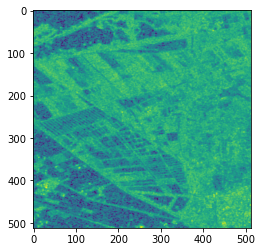

In [23]:
plt.imshow(S1_1_NORM)

In [24]:
DEM_data=tifffile.imread(dem)

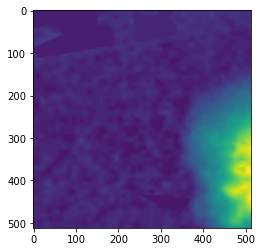

In [25]:
plt.imshow(DEM_data[0])

In [26]:
Label_data=np.uint8(rasterio.open(mas).read())
Label_data[Label_data==255]=0

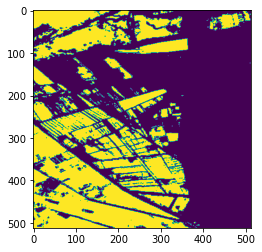

In [27]:
plt.imshow(Label_data[0])

In [28]:
NET=unet3(3,3)
checkpoint = torch.load(path+mod)
NET.load_state_dict(checkpoint)

<All keys matched successfully>

In [29]:
S10NORM = np.expand_dims(S1_0_NORM, axis=0)
S11NORM = np.expand_dims(S1_1_NORM, axis=0)
S0_NORM = torch.from_numpy(S10NORM).type(torch.FloatTensor)
S1_NORM = torch.from_numpy(S11NORM).type(torch.FloatTensor)
DEM_NORM=(DEM_data - np.min(DEM_data)) / (np.max(DEM_data) - np.min(DEM_data))
DEM = torch.from_numpy(DEM_NORM).type(torch.FloatTensor)
SUM = torch.cat((S0_NORM,S1_NORM,DEM),dim=0)
inputs=SUM.unsqueeze(0)

In [30]:
NET = NET.eval()
NET = NET.to(device)
out = NET(inputs.to(device))
a= torch.argmax(out, dim=1).cpu().numpy()

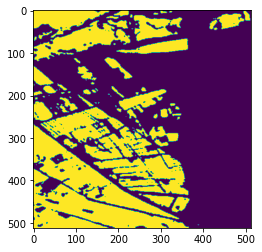

In [31]:
plt.imshow(a[0])


In [32]:
epochs

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [33]:
max_valid_iou

tensor(0.7145, device='cuda:0')

In [ ]:
rain_validation_loop(model, optimizer, train_dataloader, val_dataloader, 5, i)
    epochs.append(i)
    x = epochs
    plt.plot(x, training_losses, label='training losses')
    plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
    plt.plot(x, training_ious, 'tab:purple', label='training iou')
    plt.plot(x, valid_losses, label='valid losses')
    plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
    plt.plot(x, valid_ious, 'tab:green',label='valid iou')
    plt.legend(loc="upper left")

    display(plt.show())

    print("max valid iou:", max_valid_iou)

In [36]:
import pandas as pd

In [37]:
result =pd.DataFrame(columns=('epochs','t_loss','t_acc','t_iou','v_loss','v_acc','v_iou'))

In [38]:
result["epochs"]=epochs
result["t_loss"]=training_losses
result["t_acc"]=training_accuracies
result["t_iou"]=training_ious
result["v_loss"]=valid_losses
result["v_acc"]=valid_accuracies
result["v_iou"]=valid_ious

In [39]:
result.to_csv("old_i1i2dem_500.csv")

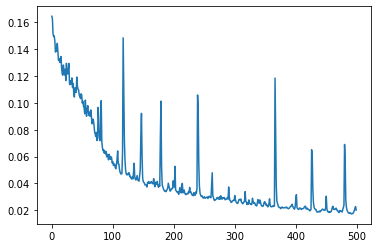

In [41]:
plt.plot(epochs, training_losses, label='training losses')

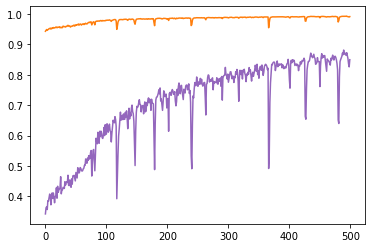

In [42]:
    plt.plot(epochs, training_accuracies, 'tab:orange', label='training accuracy')
    plt.plot(epochs, training_ious, 'tab:purple', label='training iou')

In [22]:
import matplotlib.pyplot as plt

In [6]:
model=unet3(3,3).cuda()

In [2]:
from torchsummary import summary

In [7]:
summary(model,(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             448
       BatchNorm2d-2         [-1, 16, 512, 512]              32
              ReLU-3         [-1, 16, 512, 512]               0
            Conv2d-4         [-1, 32, 512, 512]           4,640
       BatchNorm2d-5         [-1, 32, 512, 512]              64
              ReLU-6         [-1, 32, 512, 512]               0
            Conv2d-7         [-1, 64, 512, 512]          18,496
       BatchNorm2d-8         [-1, 64, 512, 512]             128
              ReLU-9         [-1, 64, 512, 512]               0
           Conv2d-10        [-1, 128, 256, 256]          73,856
      BatchNorm2d-11        [-1, 128, 256, 256]             256
             ReLU-12        [-1, 128, 256, 256]               0
           Conv2d-13        [-1, 128, 256, 256]         147,584
      BatchNorm2d-14        [-1, 128, 2

In [42]:
!pip install torchsummary

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'